In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import glob
import time
import numpy as np
import pandas as pd

import cv2
from mahotas.features import zernike_moments

from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def imshow(img, title=""):
    # Assume bgr if >= 3 dims
    if len(img.shape) >= 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Assume gray if not 3 dims
    else:
        plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
def find_largest_contour(img, thresh=10, thresh_flag=cv2.THRESH_BINARY):
    if len(img.shape) >= 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)

    _, threshed = cv2.threshold(img, thresh, 255, thresh_flag)

    contours, _ = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(largest_contour)

    mask = np.zeros(img.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    cropped_mask = mask[y : y + h, x : x + w]

    return cropped_mask, largest_contour

<IPython.core.display.Javascript object>

In [5]:
def extract_features(mask, contour, degree=8):
    radius = cv2.minEnclosingCircle(contour)[1]
    return zernike_moments(mask, radius, degree=degree)

<IPython.core.display.Javascript object>

In [6]:
answer_paths = glob.glob("pokemon_images/pokemon/*")

answers = {}
for answer_path in tqdm(answer_paths):
    basename = os.path.basename(answer_path)
    pokename = os.path.splitext(basename)[0]

    img = cv2.imread(answer_path, cv2.IMREAD_UNCHANGED)
    img[np.where(img[:, :, 3] == 0)] = [0, 0, 0, 0]

    mask, largest_contour = find_largest_contour(img)
    features = extract_features(mask, largest_contour)

    answer = {
        "image": img,
        "mask": mask,
        "contour": largest_contour,
        "features": features,
    }

    answers[pokename] = answer

<IPython.core.display.Javascript object>

In [7]:
names = list(answers.keys())
features = np.array([answers[n]["features"] for n in names])

<IPython.core.display.Javascript object>

In [8]:
nn = NearestNeighbors()
nn.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

<IPython.core.display.Javascript object>

Who's that Pokemon?!?


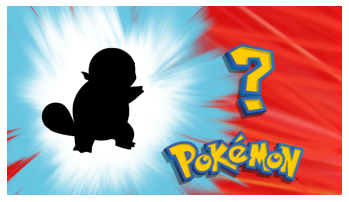

It's....
Pause for effect...
It's Squirtle!!


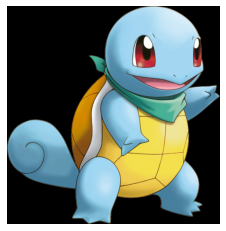

,name,dist
search_rank,,
1,squirtle,0.002922
2,charizard,0.199282
3,bulbasaur,0.214318


<IPython.core.display.Javascript object>

In [9]:
sil_paths = glob.glob("pokemon_images/silhouettes/*")
sil_path = np.random.choice(sil_paths)

sil = cv2.imread(sil_path)
print("Who's that Pokemon?!?")
imshow(sil)
print("It's....")
time.sleep(1)
print("Pause for effect...")
time.sleep(3)

mask, largest_contour = find_largest_contour(sil, thresh_flag=cv2.THRESH_BINARY_INV)
features = extract_features(mask, largest_contour)

query = [features]
dists, idxs = nn.kneighbors(query)

result_names = [names[i] for i in idxs[0]]
top_result_name = result_names[0]

result_df = pd.DataFrame({"name": result_names, "dist": dists[0]})
result_df.index += 1
result_df.index.names = ["search_rank"]

print(f"It's {result_names[0].title()}!!")
imshow(answers[top_result_name]["image"])
display(result_df.iloc[:3, :])